## The lasso and sparsity levels
Note: Make sure to read these notes on simulating data first: 

https://chalmers.instructure.com/courses/9441/pages/project-3-a-general-note-on-simulating-data

The goal of this assignment is to simulate the impact of increasing sparsity in coefficient vectors (i.e. more and more zeroes in $\beta$) and observe the performance of the lasso. No sparsity would mean that all features were used to simulate the response, whereas a sparsity of 70% would mean that only 30% of all available coefficients in $\beta$ were used to generate the response.

Every time a dataset is simulated for a set of true coefficients, a confusion matrix for the recovered coefficients compared to the true coefficients can be constructed. True positives ares coefficients that are non-zero in both the true coefficients and the estimated coefficients. False positives are non-zero coefficients in the estimated coefficients but not in the true ones (and so on).  Using the confusion matrix e.g. sensitivity and specificity can be computed. 

Answer the following questions

1. How do sensitivity and specificity change with increasing sparsity? 
    Hint: Investigate the full range of sparsity (e.g. 10% sparsity to 99% sparsity). The lasso is more sensitive in high-sparsity scenarios.
2. How does the ratio p / n affect the result?
3. How does the SNR affect the result?


General notes:

Look at results over multiple simulation runs
Packages: For R `glmnet`, for Python `scikit-learn` (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html (Links to an external site.))


### Simulate dataset for regression:

In [9]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
from sklearn import linear_model, preprocessing 

In [10]:
class dataset():  
    """
    Creates a dataset for regression,
    according to: y = X*beta + epsilon.
    add_sparsity function adds sparsity to the beta vector
    """
    
    def __init__(self, n_datapoints, p_coefficients, noise_sigma=0.5):
        self.beta = np.random.normal(scale=1, size=(p_coefficients, 1))
        self.X = np.random.normal(scale=1/(p_coefficients**0.5), size=(n_datapoints, p_coefficients)) 
        self.epsilon = np.random.normal(scale=noise_sigma, size=(n_datapoints,1))
        self.y = np.dot(self.X,self.beta) + self.epsilon 
        self.beta_sparse = self.beta
        self.n = n_datapoints
        self.p = p_coefficients
        
    def standardise_data(self):
        standard_scaled = preprocessing.StandardScaler()
        self.X = standard_scaled.fit_transform(self.X)
    
    def set_to_specific_SNR(self, gamma):
        sigma_epsilon = (( np.linalg.norm(np.dot(self.X, self.beta_sparse))**2)/(self.n - 1) )**0.5 / gamma
        self.epsilon = np.random.normal(scale=sigma_epsilon, size=(self.n,1)) 
        self.y = np.dot(self.X,self.beta_sparse) + self.epsilon 
        
    def add_sparsity(self, sparsity_percent, update_y=True):
        """
        Creates a beta vector with a given sparsity.
        """
        number_of_betas_to_zero = int(len(self.beta)*sparsity_percent)
        all_index = range(len(self.beta))
        drawn = np.random.choice(all_index, size=(number_of_betas_to_zero), replace=False)
        self.beta_sparse = self.beta.copy()
        
        for i in drawn:
            self.beta_sparse[i] = 0
            assert self.beta_sparse[i] == 0 , 'fel'
        if update_y == True:
            self.y = np.dot(self.X,self.beta_sparse) + self.epsilon 
    
    def get_SNR(self):
        """
        Returns the signal-to-noise-ratio (SNR) for current dataset
        """
        SNR = np.linalg.norm(np.dot(self.X,self.beta_sparse))/np.linalg.norm(self.epsilon)

        return SNR

def lassoCV(X, y):
    """
    Fits X and y to Lasso model for a given alpha and returns the coefficients beta_hat.
    """
    model = linear_model.LassoCV(max_iter=6000, cv=5, normalize=False)
    model.fit(X,y.ravel())
    beta_hat = model.coef_
    
    return beta_hat

def confusion_matrix(beta, beta_hat, plot=True):
    """
    If plot==True, this function plots the confusion matrix for beta compared to beta_hat. 
    This function returns sensitivity and specificity.
    """
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    
    for i in range(len(beta)):
        if beta[i] == 0:
            if beta_hat[i] == 0:
                TN += 1
            else:
                FP += 1
        elif beta[i] != 0:
            if beta_hat[i] == 0:
                FN += 1
            else:
                TP += 1

    confusion_matrix = [[TP, FN], [FP, TN]]
    
    if plot == True:
        fig, ax = plt.subplots()
        im = ax.imshow(confusion_matrix, cmap='Greens')
        ax.set_xticks(np.arange(2))
        ax.set_yticks(np.arange(2))
        ax.set_xticklabels(['Non-zero', 'Zero'])
        ax.set_yticklabels(['Non-zero', 'Zero'])
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Real')
        ax.set_title(f'Confusion matrix for beta')

        for i in range(2):
            for j in range(2):
                text = ax.text(j, i, np.array(confusion_matrix)[i,j],
                            ha="center", va="center", color="black")
    try:
        specificity = TN/(TN + FP + 0.0001)
        sensitivity = TP/(TP + FN)
    except:
        specificity = TN/(TN + FP + 0.0001)
    
    return sensitivity, specificity

## How do sensitivity and specificity change with increasing sparsity?

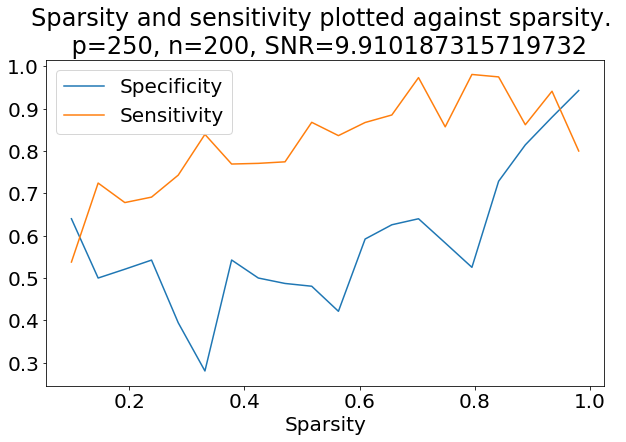

In [11]:
n= 200
p = 250
sparsity = np.linspace(0.1, 0.98, 20)
iterations = 1

sensitivity_mean = np.zeros(len(sparsity))
specificity_mean = np.zeros(len(sparsity))
SNR = []

# Repeate for  iterations, to get a mean value of the specificity and sensitivity vectors. 
for i in range(iterations):
    sensitivity = []
    specificity = []
    
    # Loop over the different sparsity levels
    for s in sparsity:
        data = dataset(n, p)
        data.standardise_data()
        
        data.add_sparsity(s)
        data.set_to_specific_SNR(10)
        
        X, y = data.X, data.y
        beta = data.beta_sparse
        beta_hat = lassoCV( X, y)

        #print(s)
        sens, spec = confusion_matrix(beta, beta_hat, plot=False)
        sensitivity.append(sens)
        specificity.append(spec)
        SNR.append(data.get_SNR())

    sensitivity_mean = sensitivity_mean + sensitivity
    specificity_mean = specificity_mean + specificity

sensitivity_mean = sensitivity_mean / iterations
specificity_mean = specificity_mean / iterations
    
# Plot figure
fig, ax = plt.subplots(figsize=(10,6))    
ax.set_title(f'Sparsity and sensitivity plotted against sparsity. \n p={p}, n={n}, SNR={data.get_SNR()}')
ax.set_xlabel('Sparsity')
plt.plot(sparsity, specificity_mean, label='Specificity')
plt.plot(sparsity, sensitivity_mean, label='Sensitivity')

plt.legend()

## How does the ratio p / n affect the result?

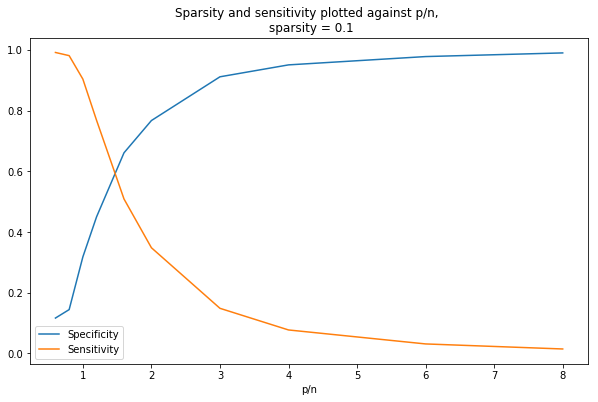

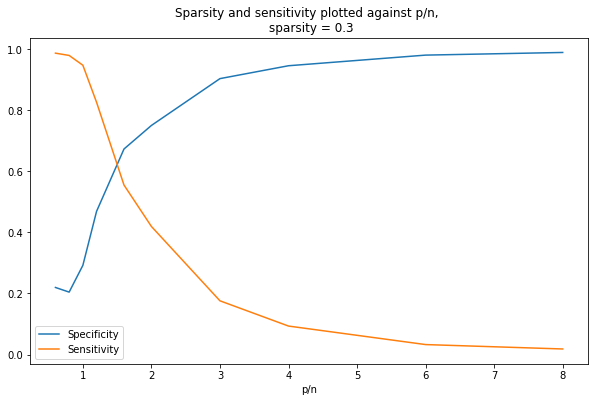

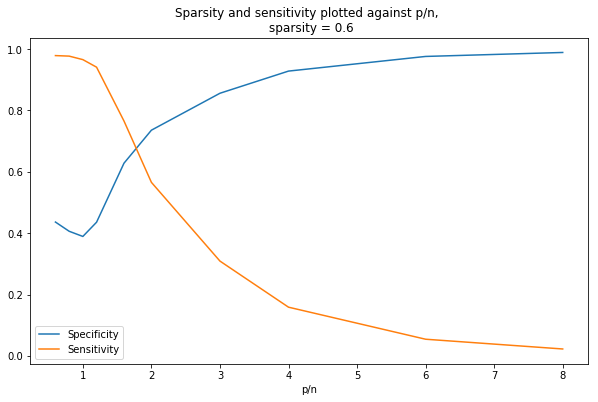

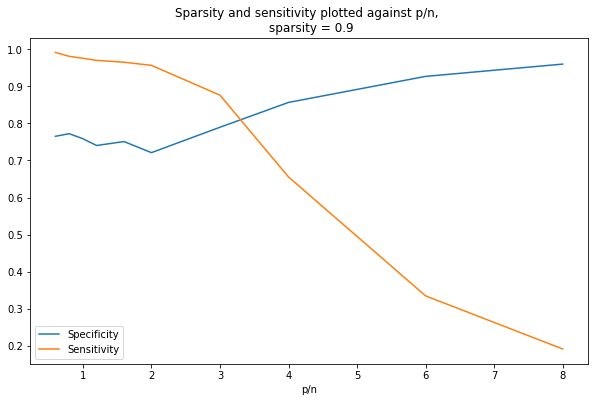

In [7]:
n = 250
p_list = [150, 200, 250, 300, 400, 500, 750, 1000, 1500, 2000]
p_divided_n = [p/n for p in p_list]
SNR = 15
sparsity = [0.1, 0.3, 0.6, 0.9]
iterations = 100

for s in sparsity:
    sensitivity_mean = np.zeros(len(p_list))
    specificity_mean = np.zeros(len(p_list))
    
    for i in range(iterations):
        sensitivity = []
        specificity = []
        for p in p_list:
            data = dataset(n, p)
            data.standardise_data()
            data.add_sparsity(s)
            data.set_to_specific_SNR(SNR)
            
            X, y = data.X, data.y
            beta = data.beta_sparse
            beta_hat = lassoCV( X, y)

            sens, spec = confusion_matrix(beta, beta_hat, plot=False)
            sensitivity.append(sens)
            specificity.append(spec)

        sensitivity_mean = sensitivity_mean + sensitivity
        specificity_mean = specificity_mean + specificity

    sensitivity_mean = sensitivity_mean / iterations
    specificity_mean = specificity_mean / iterations

    #Plot the result
    fig, ax = plt.subplots(figsize=(10,6))
    ax.set_title(f'Sparsity and sensitivity plotted against p/n, \n sparsity = {s}')
    ax.set_xlabel('p/n')
    plt.plot(p_divided_n, specificity_mean, label='Specificity')
    plt.plot(p_divided_n, sensitivity_mean, label='Sensitivity')
    plt.legend()

## How does the SNR affect the result?

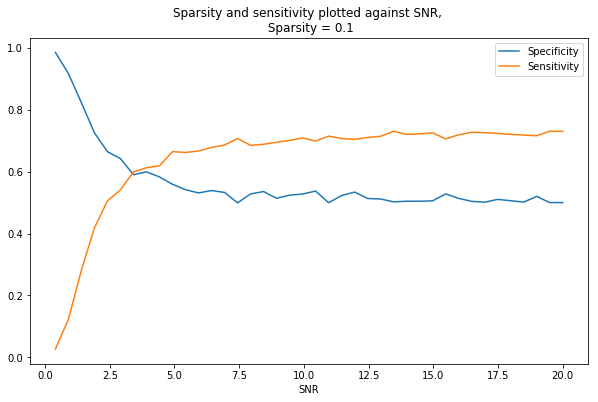

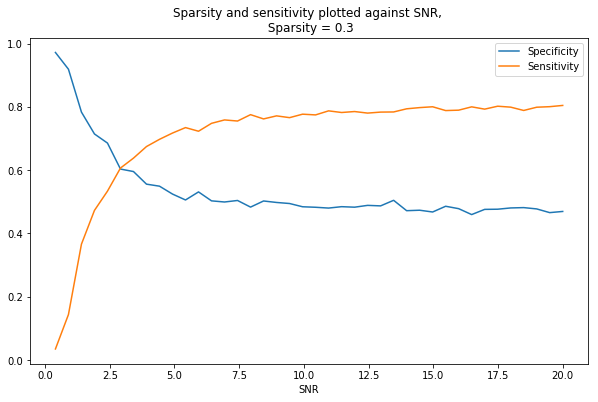

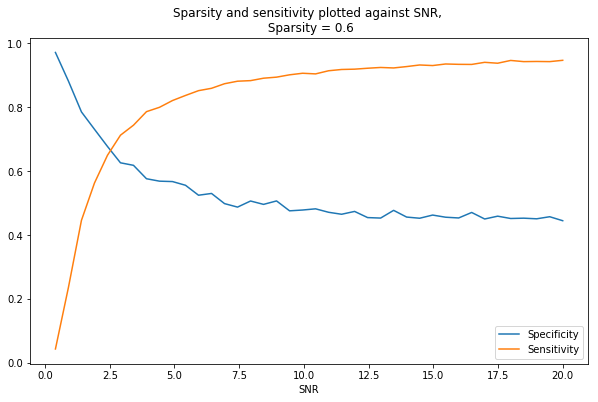

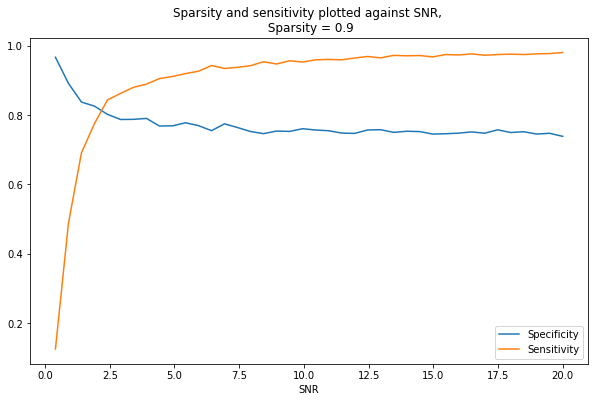

In [6]:
SNR_vector = np.linspace(0.4, 20, 40)
iterations = 100

sparsity = [0.1, 0.3, 0.6, 0.9]
for s in sparsity:
    sensitivity_mean = np.zeros(len(SNR_vector))
    specificity_mean = np.zeros(len(SNR_vector))

    for i in range(iterations):
        sensitivity = []
        specificity = []
        
        data = dataset(200,250)
        data.standardise_data()
        data.add_sparsity(s)
        
        for gamma in SNR_vector:
            data.set_to_specific_SNR(gamma)
            
            X, y = data.X, data.y
            beta = data.beta_sparse
            beta_hat = lassoCV( X, y)

            sens, spec = confusion_matrix(beta, beta_hat, plot=False)
            sensitivity.append(sens)
            specificity.append(spec)

        sensitivity_mean = sensitivity_mean + sensitivity
        specificity_mean = specificity_mean + specificity

    sensitivity_mean = sensitivity_mean / iterations
    specificity_mean = specificity_mean / iterations

    # Plot figure
    fig, ax = plt.subplots(figsize=(10,6))
    ax.set_title(f'Sparsity and sensitivity plotted against SNR, \n Sparsity = {s}')
    ax.set_xlabel('SNR')
    plt.plot(SNR_vector, specificity_mean, label='Specificity')
    plt.plot(SNR_vector, sensitivity_mean, label='Sensitivity')
    plt.legend()